# Encoder nach Dennis:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

mpl.rcParams['figure.figsize'] = (15, 5)

np.random.seed(42)

### Trainingsdata:

In [2]:
spectogram_data = np.load("data\spectos.npy")
song_labels = np.load("data\song_labels.npy")
position_labels = np.load("data\position_labels.npy")
#spectogram_data = spectogram_data[..., np.newaxis]
print(spectogram_data.shape)
song_labels.shape

(563276, 128, 8, 1)


(563276,)

### Encoder:

In [3]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 8, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2),
], name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 4, 32)         544       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 2, 32)         16416     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 82,594
Trainable params: 82,594
Non-trainable

In [4]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    # we want this layer to have the same dimension as the first dense layer
    # so we can go "backwards" as we have gone "forwards"
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32*2*64),
    # reshape from a vector to a multidimensional array (image)
    tf.keras.layers.Reshape((32, 2, 64)),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    # back to the 1 dimensional black/white image
    tf.keras.layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', activation='leaky_relu'),
], name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 4096)              266240    
                                                                 
 reshape (Reshape)           (None, 32, 2, 64)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 4, 64)        65600     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 8, 32)       32800     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 8, 1)        513 

In [5]:
autoencoder = tf.keras.models.Model(encoder.input, decoder(encoder.output), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 8, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 4, 32)         544       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 2, 32)         16416     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 

In [6]:
spectogram_data.shape

(563276, 128, 8, 1)

In [7]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=lambda y_true, y_pred: K.mean(K.square(y_true - y_pred), axis=[1, 2, 3]),
)

autoencoder.fit(
    x=spectogram_data,
    # use the input as the target
    y=spectogram_data,
    batch_size=10,
    shuffle=True,
    epochs=20,
)

Epoch 1/20
56328/56328 [==============================] - 1093s 19ms/step - loss: 137.3905
Epoch 2/20
56328/56328 [==============================] - 1037s 18ms/step - loss: 131.5119
Epoch 3/20
56328/56328 [==============================] - 1033s 18ms/step - loss: 130.6389
Epoch 4/20
56328/56328 [==============================] - 1139s 20ms/step - loss: 130.1471
Epoch 5/20
56328/56328 [==============================] - 1218s 22ms/step - loss: 129.7574
Epoch 6/20
56328/56328 [==============================] - 1200s 21ms/step - loss: 129.5626
Epoch 7/20
56328/56328 [==============================] - 1352s 24ms/step - loss: 129.3639
Epoch 8/20
56328/56328 [==============================] - 1247s 22ms/step - loss: 129.1989
Epoch 9/20
56328/56328 [==============================] - 1028s 18ms/step - loss: 129.1395
Epoch 10/20
56328/56328 [==============================] - 991s 18ms/step - loss: 128.9596
Epoch 11/20
56328/56328 [==============================] - 1074s 19ms/step - loss: 128.898

### Latent space Repräsentation:

In [8]:
latent_representation = encoder.predict(spectogram_data)
latent_representation.shape

(563276, 2)

#### latent_representation ist ein zweidimensionales Array, das die Koordinaten aller Wavesets im Latent space enthält.

In [9]:
i = 2
print(latent_representation[i])

[-1.6198497 83.687965 ]


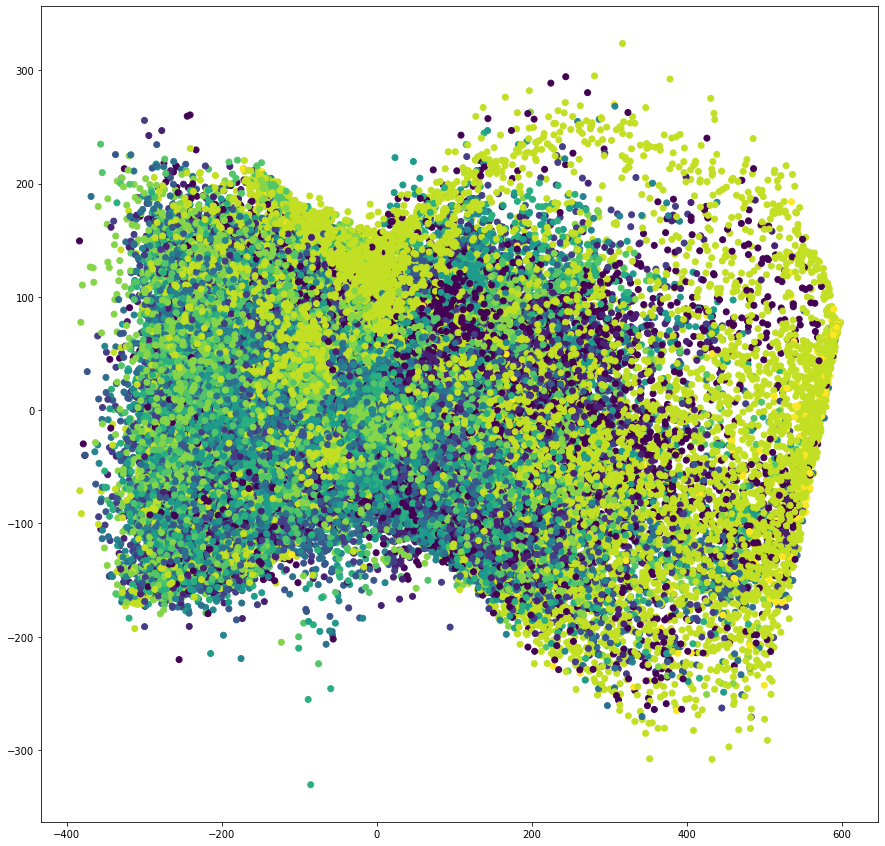

In [10]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=position_labels)

1D Array mit Anzahl der Wavesets pro Song:

In [11]:
num_of_ws_per_song = np.load("data/num_of_ws_per_song.npy")
num_of_ws_per_song.shape
#print(num_of_ws_per_song)

(24,)

#### Array aus latent_representation und Anzahl der Wavesets pro Song

In [12]:
song_orders = [latent_representation[num_of_ws_per_song[0:i].sum():num_of_ws_per_song[0:i+1].sum(), :] for i in range(0, len(num_of_ws_per_song))]
print(song_orders[0:1])

[array([[ 1.46479904e+02,  1.24402008e+02],
       [ 3.84128304e+01,  1.25033211e+02],
       [-1.61984968e+00,  8.36879654e+01],
       [-1.98426342e+01,  8.52111969e+01],
       [-4.04999657e+01,  1.08662003e+02],
       [-4.63464508e+01,  1.10260422e+02],
       [-5.32762947e+01,  1.18126556e+02],
       [-6.31400108e+01,  1.16157089e+02],
       [-5.25938301e+01,  1.09752335e+02],
       [-5.14881325e+01,  1.16057480e+02],
       [-5.76035194e+01,  1.08662727e+02],
       [-6.02465553e+01,  1.22319183e+02],
       [-6.17819786e+01,  1.21025879e+02],
       [-5.34285774e+01,  1.19038696e+02],
       [-5.77534752e+01,  1.04876617e+02],
       [-6.65838394e+01,  1.14248993e+02],
       [-7.31795731e+01,  1.23355194e+02],
       [-7.69506531e+01,  1.18200798e+02],
       [-5.78280678e+01,  1.09836983e+02],
       [-6.31430664e+01,  9.82327118e+01],
       [-3.47254753e+01,  9.78037109e+01],
       [-5.52588844e+01,  7.37713013e+01],
       [-2.39425678e+01,  8.32816162e+01],
       [-6

### Save Data
Save data in .txt on disk for later use.

In [ ]:
song_orders = [[[12.68275, -2.3526],[198.431, 67.430]],[[-4.896, -69.123]]] #example list
with open("data/song_orders.txt", "wb") as fp:
    pickle.dump(song_orders, fp)

The data can be loaded like this:

In [ ]:
with open("data/song_orders.txt", "rb") as fp:
    song_orders = pickle.load(fp)

print(song_orders)